In [31]:
# Import Libraries
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingClassifier as hgbc
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TunedThresholdClassifierCV
import pandas as pd
import numpy as np
import pickle, shap, warnings
warnings.filterwarnings("ignore")

In [32]:
# Load Dataset
df = pd.read_csv('../data/prepared_data.csv')
df

,resp_id_KALRO,location_KALRO,treatment,treated,age_b,d_young_b,female_b,secondary_b,footwear_b,mumias_b,...,P_a_ureakg_18,P_a_picsqty_18,id,program,followed_lime_1all,followed_fert_1all,primary_all,hear_knows_lime_b,age_decades,age_squared
0,11004.0,1.0,Control,0,39.0,1.0,0.0,0.0,1.0,0.0,...,NaN,NaN,KALRO11004,KALRO,1,0.0,1.0,1.0,3.9,15.21
1,11005.0,1.0,Treated,1,24.0,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,KALRO11005,KALRO,0,1.0,1.0,0.0,2.4,5.76
2,11006.0,1.0,Treated,1,35.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,KALRO11006,KALRO,0,1.0,0.0,1.0,3.5,12.25
3,11007.0,1.0,Treated,1,54.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,KALRO11007,KALRO,1,1.0,0.0,0.0,5.4,29.16
4,11008.0,1.0,Control,0,27.0,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,KALRO11008,KALRO,0,1.0,1.0,1.0,2.7,7.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128884,NaN,NaN,Control,0,22.0,1.0,0.0,0.0,NaN,NaN,...,NaN,NaN,PAD29702236,PAD2,0,0.0,0.0,0.0,2.2,4.84
128885,NaN,NaN,SMS,1,32.0,1.0,0.0,0.0,NaN,NaN,...,NaN,NaN,PAD29702237,PAD2,1,0.0,1.0,0.0,3.2,10.24
128886,NaN,NaN,SMS,1,26.0,1.0,1.0,0.0,NaN,NaN,...,NaN,NaN,PAD29702238,PAD2,0,0.0,0.0,0.0,2.6,6.76
128887,NaN,NaN,SMS,1,23.0,1.0,0.0,0.0,NaN,NaN,...,NaN,NaN,PAD29702239,PAD2,0,0.0,1.0,0.0,2.3,5.29


In [33]:
def downcast(df, verbose = True):
    start_memory = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object" or 'date' in dtype_name:
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast = "integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast = "float")
    end_memory = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print("{:.1f}% compressed".format(100 * (start_memory - end_memory) / start_memory))
    return df
df = downcast(df)

49.4% compressed


In [34]:
# Drop rows that didn't look at fertilizer
df = df[df['followed_fert_1all'].notna()]
df.shape

(41132, 238)

In [35]:
y_fert = df['followed_fert_1all']

X_pooled_basic = df[['treated','female_b','primary_all','large_shamba_b','d_young_b','ever_used_lime_b','hear_knows_lime_b','program']]

# encode program into a numeric variable
X_pooled_basic['program'] = X_pooled_basic['program'].astype('category').cat.codes
# Turn program into dummies
X_pooled_basic = pd.get_dummies(X_pooled_basic, columns=['program'], drop_first=False, dtype=int)

# Interact variables
for col in ['female_b','primary_all','large_shamba_b','d_young_b','ever_used_lime_b','hear_knows_lime_b']:
    X_pooled_basic[f'{col}_treat'] = X_pooled_basic[col] * X_pooled_basic['treated']

    for i in range(4):
        X_pooled_basic[f'{col}_program_{i}'] = X_pooled_basic[col] * X_pooled_basic[f'program_{i}']

In [36]:
df['acidity'] = 7-df['ph_prediction_b']
df['acidity_squared'] = df['acidity'] ** 2
df['farm_size'] = df['size_shamba_b']
df['farm_size_squared'] = df['farm_size'] ** 2
df['num_messages_squared'] = df['num_messages'] ** 2

In [37]:
# Training the basic model
model = hgbc(
    learning_rate=0.01,
    class_weight='balanced',
    min_samples_leaf=31,
    l2_regularization=0,
    max_features=1.0,
    max_leaf_nodes=None,
    max_depth=None,
    early_stopping=True,
    n_iter_no_change=100,
    scoring='roc_auc',
    verbose=1,
    max_iter = 2000,
    random_state=42
)

model.fit(X_pooled_basic, y_fert)
pickle.dump(model, open('../output/models/basic_model_fert.pkl', 'wb'))
print(f"Basic Model AUROC: {roc_auc_score(y_fert, model.predict_proba(X_pooled_basic)[:, 1])}")

Binning 0.012 GB of training data: 

0.016 s
Binning 0.001 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
Fit 131 trees in 2.061 s, (14733 total leaves)
Time spent computing histograms: 0.616s
Time spent finding best splits:  0.156s
Time spent applying splits:      0.259s
Time spent predicting:           0.019s
Basic Model AUROC: 0.652974480276698


In [38]:
# Optimal balanced accuracy
calibration = TunedThresholdClassifierCV(
    model,
    scoring='balanced_accuracy',
    cv='prefit',
    refit=False,
    random_state=1234
    ).fit(X_pooled_basic, y_fert)

print("Optimal threshold:", calibration.best_threshold_)
print(f"Best balanced accuracy: {balanced_accuracy_score(y_fert, calibration.predict(X_pooled_basic))}")

Optimal threshold: 0.4924666096721416
Best balanced accuracy: 0.6077997637080792


In [39]:
X_pooled_large = df[['treated','female_b','primary_all','ever_used_lime_b','hear_knows_lime_b','program','family_treatment',
'farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared','acidity','acidity_squared']]

# encode program into a numeric variable
X_pooled_large['program'] = X_pooled_large['program'].astype('category').cat.codes
# Turn program into dummies
X_pooled_large = pd.get_dummies(X_pooled_large, columns=['program'], drop_first=False, dtype=int)

# Rescale the numeric columns
cols_to_rescale = ['farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared','acidity','acidity_squared']
scaler = MinMaxScaler()
X_pooled_large[cols_to_rescale] = scaler.fit_transform(X_pooled_large[cols_to_rescale])

# Interact variables
for col in ['female_b','primary_all','ever_used_lime_b','hear_knows_lime_b','family_treatment','farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared','acidity','acidity_squared']:
    X_pooled_large[f'{col}_treat'] = X_pooled_large[col] * X_pooled_large['treated']

# Additional interactions
# female
for col in ['primary_all','ever_used_lime_b','hear_knows_lime_b','family_treatment','farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared','acidity','acidity_squared']:
    X_pooled_large[f'{col}_female'] = X_pooled_large[col] * X_pooled_large['female_b']

# Used lime before
for col in ['primary_all','farm_size','farm_size_squared','age_decades','age_squared','num_messages','num_messages_squared']:
    X_pooled_large[f'{col}_lime_before'] = X_pooled_large[col] * X_pooled_large['ever_used_lime_b']

In [40]:
# Training large model
model = hgbc(
    learning_rate=0.01,
    class_weight='balanced',
    min_samples_leaf=100,
    l2_regularization=0,
    max_features=1.0,
    max_leaf_nodes=None,
    max_depth=None,
    early_stopping=True,
    n_iter_no_change=100,
    scoring='roc_auc',
    verbose=1,
    max_iter = 2000,
    random_state=42
)

model.fit(X_pooled_large, y_fert)
print(f"Large Model In-sample AUROC: {roc_auc_score(y_fert, model.predict_proba(X_pooled_large)[:, 1])}")

Binning 0.015 GB of training data: 

0.030 s
Binning 0.002 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
Fit 389 trees in 11.255 s, (107498 total leaves)
Time spent computing histograms: 3.362s
Time spent finding best splits:  1.175s
Time spent applying splits:      2.007s
Time spent predicting:           0.069s
Large Model In-sample AUROC: 0.8593167592649148


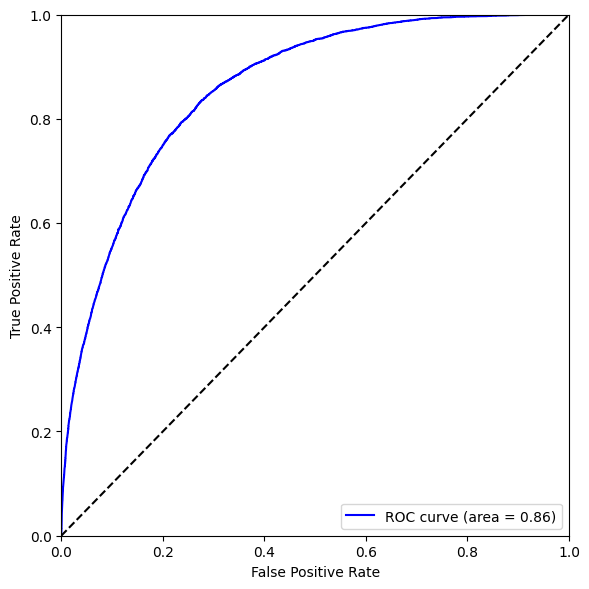

In [41]:
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_fert, model.predict_proba(X_pooled_large)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('../output/lightgbm_roc_fert.pdf')

In [42]:
# Optimal balanced accuracy
calibration = TunedThresholdClassifierCV(
    model,
    scoring='balanced_accuracy',
    cv='prefit',
    refit=False,
    random_state=1234
    ).fit(X_pooled_large, y_fert)

pickle.dump(calibration, open('../output/models/large_model_fert.pkl', 'wb'))

print("Optimal threshold:", calibration.best_threshold_)
print(f"Best balanced accuracy: {balanced_accuracy_score(y_fert, calibration.predict(X_pooled_large))}")

Optimal threshold: 0.46192400596385524
Best balanced accuracy: 0.7788217645395251


In [43]:
# sample 1000 rows from x_eval
x_sample = X_pooled_large.sample(n=1000, random_state=1234)
# shap values
explainer = shap.TreeExplainer(model, x_sample, feature_names=X_pooled_large.columns, model_output='probability')
shap_values = explainer(x_sample, check_additivity=True)

100%|===================| 999/1000 [00:51<00:00]        

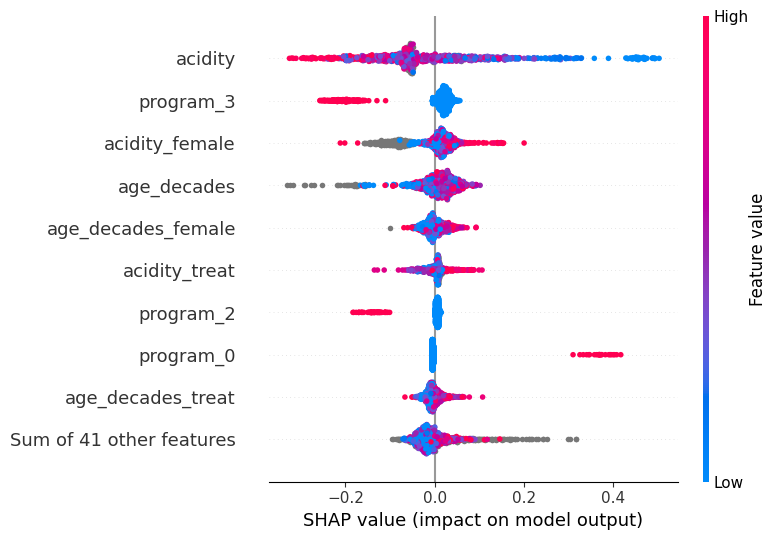

In [44]:
fig = plt.figure(figsize=(10, 15))
fig.add_axes(shap.plots.beeswarm(shap_values, max_display=10, show=False))
fig.tight_layout()
fig.savefig('../output/shap_beeswarm_fert.pdf')